<a href="https://colab.research.google.com/github/minddong59/Dacon/blob/main/seoulbike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 따릉이 데이터를 활용한 데이터 분석

각 날짜의 1시간 전의 기상상황을 가지고 1시간 후의 따릉이 대여수를 예측해보세요.

In [1]:
import pandas as pd #판다스 패키지 불러오기
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor #랜덤 포레스트 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/따릉이 예측하기/train.csv')
test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/따릉이 예측하기/test.csv')
submission=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/따릉이 예측하기/submission.csv')

In [4]:
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


+ id : 날짜와 시간별 id
+ hour_bef_temperature : 1시간 전 기온
+ hour_bef_precipitation : 1시간 전 비 정보, 비가 오지 않았으면 0, 비가 오면 1
+ hour_bef_windspeed : 1시간 전 풍속(평균)
+ hour_bef_humidity : 1시간 전 습도
+ hour_bef_visibility : 1시간 전 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
+ hour_bef_ozone : 1시간 전 오존
+ hour_bef_pm10 : 1시간 전 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
+ hour_bef_pm2.5 : 1시간 전 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
+ count : 시간에 따른 따릉이 대여 수 

In [5]:
test.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      715 non-null    int64  
 1   hour                    715 non-null    int64  
 2   hour_bef_temperature    714 non-null    float64
 3   hour_bef_precipitation  714 non-null    float64
 4   hour_bef_windspeed      714 non-null    float64
 5   hour_bef_humidity       714 non-null    float64
 6   hour_bef_visibility     714 non-null    float64
 7   hour_bef_ozone          680 non-null    float64
 8   hour_bef_pm10           678 non-null    float64
 9   hour_bef_pm2.5          679 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 56.0 KB


In [8]:
train.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1459.000000,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,1651.000000,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


In [9]:
test.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
count,715.000000,715.000000,714.000000,714.000000,714.000000,714.000000,714.000000,680.000000,678.000000,679.000000
mean,1056.854545,11.472727,23.263305,0.051821,2.388515,56.668067,1359.494398,0.041196,36.930678,24.939617
std,625.574471,6.928427,4.039645,0.221820,1.171270,19.661880,614.171870,0.020656,12.641503,10.075857
min,0.000000,0.000000,14.600000,0.000000,0.000000,16.000000,126.000000,0.003000,9.000000,7.000000
25%,507.000000,5.500000,20.300000,0.000000,1.500000,42.000000,807.250000,0.027000,28.000000,17.000000
50%,1046.000000,11.000000,22.900000,0.000000,2.300000,55.000000,1489.000000,0.039000,35.000000,24.000000
75%,1616.500000,17.000000,26.375000,0.000000,3.275000,73.750000,2000.000000,0.052250,45.000000,31.000000
max,2177.000000,23.000000,33.800000,1.000000,5.900000,100.000000,2000.000000,0.138000,94.000000,69.000000


- 기술통계량 종류
 - count: 해당 column에서 비어 있지 않은 값의 개수
 - mean: 평균
 - std: 표준편차
 - min: 최솟값 (이상치 포함)
 - 25% (Q1): 전체 데이터를 순서대로 정렬했을 때, 아래에서 부터 1/4번째 지점에 있는 값
 - 50% (Q2): 중앙값 (전체 데이터를 순서대로 정렬했을 때, 아래에서 부터 2/4번째 지점에 있는 값)
 - 75% (Q3): 전체 데이터를 순서대로 정렬했을 때, 아래에서 부터 3/4번째 지점에 있는 값
 - max: 최댓값 (이상치 포함) 

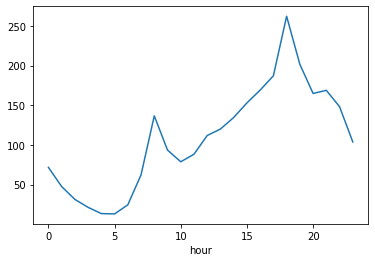

In [15]:
train.groupby('hour').mean()['count'].plot()

In [16]:
import matplotlib.pyplot as plt

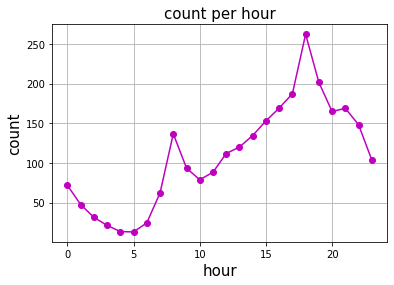

In [27]:
plt.plot(train.groupby('hour').mean()['count'],'mo-')
plt.title('count per hour',fontsize=15)
plt.xlabel('hour',fontsize=15)
plt.ylabel('count',fontsize=15)
plt.grid()
plt.savefig('countgraph.png')

### plt.plot()의 스타일

색깔

|문자열|약자|
|----|-----|
|blue|b|
|green|g|
|red|r|
|cyan|c|
|magenta|m|
|yellow|y|
|black|k|
|white|w|

마커

|마커|의미|
|----|----|
|.|점|
|o|원|
|v|역삼각형|
|^|삼각형|
|s|사각형|
|*|별|
|x|엑스|
|d|다이아몬드|

선

|문자열|의미|
|-----|-----|
| - | 실선|
|-- | 끊어진 실선|
| -.| 점+실선|
|:|점선|

### 상관계수

- 상관계수: 두 개의 변수가 같이 일어나는 강도를 나타내는 수치 
- -1에서 1사이의 값을 지닙니다. 
- -1이나 1인 수치는 현실 세계에서 관측되기 힘든 수치입니다. 
- 분야별로 기준을 정하는 것에 따라 달라지겠지만, 보통 0.4이상이면 두 개의 변수간에 상관성이 있다고 얘기합니다.

In [28]:
train.corr() #correlation coefficient

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
id,1.000000,-0.010901,-0.000029,-0.056267,-0.003353,-0.017948,0.008950,0.055234,-0.025510,0.003545,-0.002131
hour,-0.010901,1.000000,0.407306,0.021646,0.462797,-0.329612,0.176491,0.390188,-0.035907,-0.061229,0.626047
hour_bef_temperature,-0.000029,0.407306,1.000000,-0.097056,0.375618,-0.496088,0.197417,0.541228,-0.003830,-0.078665,0.619404
hour_bef_precipitation,-0.056267,0.021646,-0.097056,1.000000,0.022746,0.276481,-0.217155,-0.062461,-0.051266,0.004742,-0.163985
hour_bef_windspeed,-0.003353,0.462797,0.375618,0.022746,1.000000,-0.433012,0.252092,0.520526,0.010176,-0.199113,0.459906
hour_bef_humidity,-0.017948,-0.329612,-0.496088,0.276481,-0.433012,1.000000,-0.592244,-0.421047,-0.108106,0.167736,-0.471142
hour_bef_visibility,0.008950,0.176491,0.197417,-0.217155,0.252092,-0.592244,1.000000,0.101899,-0.403277,-0.644989,0.299094
hour_bef_ozone,0.055234,0.390188,0.541228,-0.062461,0.520526,-0.421047,0.101899,1.000000,0.113015,0.017313,0.477614
hour_bef_pm10,-0.025510,-0.035907,-0.003830,-0.051266,0.010176,-0.108106,-0.403277,0.113015,1.000000,0.489558,-0.114288
hour_bef_pm2.5,0.003545,-0.061229,-0.078665,0.004742,-0.199113,0.167736,-0.644989,0.017313,0.489558,1.000000,-0.134293


In [29]:
test.corr() #correlation coefficient

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
id,1.000000,-0.023110,-0.024285,-0.080214,0.019491,0.025796,-0.022034,0.009907,0.022468,0.036927
hour,-0.023110,1.000000,0.482014,0.006297,0.503153,-0.355165,0.203000,0.370070,0.105012,0.060712
hour_bef_temperature,-0.024285,0.482014,1.000000,-0.233748,0.372406,-0.579471,0.143118,0.552657,0.344240,0.312587
hour_bef_precipitation,-0.080214,0.006297,-0.233748,1.000000,-0.098653,0.390806,-0.312142,-0.079594,-0.152279,-0.071372
hour_bef_windspeed,0.019491,0.503153,0.372406,-0.098653,1.000000,-0.396020,0.212222,0.521737,0.138788,0.047929
hour_bef_humidity,0.025796,-0.355165,-0.579471,0.390806,-0.396020,1.000000,-0.689857,-0.404301,-0.008442,0.198467
hour_bef_visibility,-0.022034,0.203000,0.143118,-0.312142,0.212222,-0.689857,1.000000,-0.030971,-0.446661,-0.607991
hour_bef_ozone,0.009907,0.370070,0.552657,-0.079594,0.521737,-0.404301,-0.030971,1.000000,0.443571,0.397606
hour_bef_pm10,0.022468,0.105012,0.344240,-0.152279,0.138788,-0.008442,-0.446661,0.443571,1.000000,0.909827
hour_bef_pm2.5,0.036927,0.060712,0.312587,-0.071372,0.047929,0.198467,-0.607991,0.397606,0.909827,1.000000


In [30]:
train.isna().sum() #결측값 갯수 확인

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

#기온 결측치 전처리

In [32]:
train[train['hour_bef_temperature'].isna()] #기온 결측치 인덱스 찾기

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
934,1420,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [33]:
train.groupby('hour').mean()['hour_bef_temperature'] #시간별 평균 기온

hour
0     14.788136
1     14.155738
2     13.747541
3     13.357377
4     13.001639
5     12.673770
6     12.377049
7     12.191803
8     12.600000
9     14.318033
10    16.242623
11    18.019672
12    19.457377
13    20.648333
14    21.234426
15    21.744262
16    22.015000
17    21.603333
18    20.926667
19    19.704918
20    18.191803
21    16.978333
22    16.063934
23    15.418033
Name: hour_bef_temperature, dtype: float64

In [35]:
train.mean()['hour_bef_temperature'] #전체적 평균기온

16.717433081674653

In [39]:
train['hour_bef_temperature'].fillna({934:14.788136, 1035:20.926667},inplace=True) #결측치 임의 입력

inplace=True를 안하면 입력만 되고 저장이 안됨

In [48]:
train.loc[[934,1035],:] #확인

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
934,1420,0,14.788136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,20.926667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


#풍속 결측치 전처리

In [65]:
train[train['hour_bef_windspeed'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count


In [50]:
train.groupby('hour').mean()['hour_bef_windspeed']

hour
0     1.965517
1     1.836667
2     1.633333
3     1.620000
4     1.409836
5     1.296721
6     1.331148
7     1.262295
8     1.632787
9     1.829508
10    2.122951
11    2.485246
12    2.766667
13    3.281356
14    3.522951
15    3.768852
16    3.820000
17    3.801667
18    3.838333
19    3.595082
20    3.278333
21    2.755000
22    2.498361
23    2.195082
Name: hour_bef_windspeed, dtype: float64

In [61]:
train['hour_bef_windspeed'].fillna({18:3.281356, 244:1.836667, 260:1.620000, 376:1.965517, 780:3.278333, 934:1.965517, 1035:3.838333, 1138:2.766667, 1229:1.633333},inplace=True)

테스트 세트도 결측값 처리 해줄거임!

In [89]:
test.isna().sum()

id                         0
hour                       0
hour_bef_temperature       0
hour_bef_precipitation     1
hour_bef_windspeed         0
hour_bef_humidity          1
hour_bef_visibility        1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64

In [72]:
test[test['hour_bef_temperature'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
653,1943,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
test.groupby('hour').mean()['hour_bef_temperature']

hour
0     21.386667
1     20.986667
2     20.600000
3     20.203333
4     19.853333
5     19.634483
6     19.243333
7     19.190000
8     19.846667
9     21.266667
10    22.683333
11    24.110000
12    25.430000
13    26.630000
14    27.473333
15    28.040000
16    28.255172
17    27.848276
18    27.010345
19    26.110345
20    24.803333
21    23.696552
22    22.523333
23    21.926667
Name: hour_bef_temperature, dtype: float64

In [82]:
test['hour_bef_temperature'].fillna({653:26.110345},inplace=True)

In [88]:
test[test['hour_bef_windspeed'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5


In [86]:
test.groupby('hour').mean(['hour_bef_windspeed'])

,id,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
hour,,,,,,,,,
0,984.700000,21.386667,0.033333,1.986667,63.200000,1468.100000,0.029933,34.833333,23.200000
1,1040.266667,20.986667,0.066667,1.840000,65.000000,1340.733333,NaN,NaN,NaN
2,1038.733333,20.600000,0.066667,1.823333,67.266667,1254.833333,0.029400,35.033333,23.600000
3,1125.700000,20.203333,0.033333,1.636667,68.700000,1240.500000,0.031267,34.466667,24.366667
4,1147.500000,19.853333,0.033333,1.543333,69.600000,1230.600000,0.032833,33.800000,23.633333
5,954.620690,19.634483,0.034483,1.589655,70.034483,1161.241379,0.032690,34.172414,24.310345
6,1270.633333,19.243333,0.100000,1.396667,72.333333,1107.833333,0.031633,34.666667,24.133333
7,957.466667,19.190000,0.100000,1.453333,71.900000,1080.633333,0.028100,35.966667,24.933333
8,1096.566667,19.846667,0.100000,1.446667,67.700000,1095.600000,0.025800,35.533333,24.833333


In [87]:
test['hour_bef_windspeed'].fillna({653:3.541379},inplace=True)

변수 선택

In [90]:
features=['hour','hour_bef_temperature','hour_bef_windspeed']

In [91]:
X_train = train[features]
Y_train = train['count']
X_test = test[features]

In [93]:
model100 =RandomForestRegressor(n_estimators=100, random_state=0)
model100_5=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
model200 =RandomForestRegressor(n_estimators=200, random_state=0)

In [95]:
model100.fit(X_train,Y_train)
model100_5.fit(X_train,Y_train)
model200.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [96]:
yprediction100 = model100.predict(X_test)
yprediction100_5 = model100_5.predict(X_test)
yprediction200 = model200.predict(X_test)

In [101]:
submission['count']=yprediction100
submission.to_csv('model100.csv',index=False)

In [104]:
submission['count']=yprediction100_5
submission.to_csv('model100_5.csv',index=False)

In [102]:
submission['count']=yprediction200
submission.to_csv('model200.csv',index=False)